# Decision tree

Натренувати класифікатор на датасеті

https://archive.ics.uci.edu/ml/datasets/credit+approval

In [34]:
# Підключаємо Google Drive з датасетами
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Імпортуємо всі необхідні бібліотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

%config InlineBackend.figure_format = "png"

# зчитуємо набір даних
datasets_path = "/content/drive/MyDrive/Colab Notebooks/credit_approval/"
df = pd.read_csv(datasets_path + "crx.data")

In [36]:
!pip install category_encoders

In [37]:
# Проведемо первинний аналіз даних датасету скла
print("Загальний опис датасету:", df.info(), "\n")
print(df.isna().sum(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b       689 non-null    object 
 1   30.83   689 non-null    object 
 2   0       689 non-null    float64
 3   u       689 non-null    object 
 4   g       689 non-null    object 
 5   w       689 non-null    object 
 6   v       689 non-null    object 
 7   1.25    689 non-null    float64
 8   t       689 non-null    object 
 9   t.1     689 non-null    object 
 10  01      689 non-null    int64  
 11  f       689 non-null    object 
 12  g.1     689 non-null    object 
 13  00202   689 non-null    object 
 14  0.1     689 non-null    int64  
 15  +       689 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.2+ KB
Загальний опис датасету: None 

b        0
30.83    0
0        0
u        0
g        0
w        0
v        0
1.25     0
t        0
t.1      0
01       0
f        0
g

In [38]:
# Перевіряємо чи є дублікати
df.duplicated().sum()

0

Датасет має 16 колонок. Пустих значень та дублікатів не має.

Можемо побачити, що в датасеті немає імен колонок. Але вони є у файлі `glass.names`, який йде разом з датасетом. Тож задамо імена для колонок згідно опису в файлі:
```
7.  Attribute Information:

    A1:	b, a.
    A2:	continuous.
    A3:	continuous.
    A4:	u, y, l, t.
    A5:	g, p, gg.
    A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
    A7:	v, h, bb, j, n, z, dd, ff, o.
    A8:	continuous.
    A9:	t, f.
    A10:	t, f.
    A11:	continuous.
    A12:	t, f.
    A13:	g, p, s.
    A14:	continuous.
    A15:	continuous.
    A16: +,-         (class attribute)
```



In [39]:
# Додаємо назви колонок для датафрейму
df.columns =[f"A{x}" for x in range(1, 17)]

In [40]:
# Тепер подивимось на перші записи
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
1,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
2,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
3,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
4,b,32.08,4.000,u,g,m,v,2.50,t,f,0,t,g,00360,0,+


In [41]:
# Та подивимось на описову статистику (яка зараз буде не повною через наявність багатої кількості категоріальних фічей)
df.describe()

,A3,A8,A11,A15
count,689.000000,689.000000,689.000000,689.000000
mean,4.765631,2.224819,2.402032,1018.862119
std,4.978470,3.348739,4.866180,5213.743149
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.165000,0.000000,0.000000
50%,2.750000,1.000000,0.000000,5.000000
75%,7.250000,2.625000,3.000000,396.000000
max,28.000000,28.500000,67.000000,100000.000000


In [42]:
# Згідно опису датасету, деякі записи містят пусті значення. Порахуємо їх.
empty = df[
    (df["A1"] == "?") |
    (df["A2"] == "?") |
    (df["A4"] == "?") |
    (df["A5"] == "?") |
    (df["A6"] == "?") |
    (df["A7"] == "?") |
    (df["A14"] == "?")
]
empty.count()

A1     37
A2     37
A3     37
A4     37
A5     37
A6     37
A7     37
A8     37
A9     37
A10    37
A11    37
A12    37
A13    37
A14    37
A15    37
A16    37
dtype: int64

In [43]:
# Так, маємо 37 записів з пустими значеннями. Так як ми достовірно не знаємо, що то за значення там можуть бути, а розмірність датасету дозволяє їх видалити - тож видаляємо
df = df.drop(empty.index, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      652 non-null    object 
 1   A2      652 non-null    object 
 2   A3      652 non-null    float64
 3   A4      652 non-null    object 
 4   A5      652 non-null    object 
 5   A6      652 non-null    object 
 6   A7      652 non-null    object 
 7   A8      652 non-null    float64
 8   A9      652 non-null    object 
 9   A10     652 non-null    object 
 10  A11     652 non-null    int64  
 11  A12     652 non-null    object 
 12  A13     652 non-null    object 
 13  A14     652 non-null    object 
 14  A15     652 non-null    int64  
 15  A16     652 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.6+ KB


In [44]:
# Тепер приведемо до належних типів типи даних у деяких колонках. Бо зараз вони мають не ті типи, що мають мати згідно опису датасету
df = df.astype(
    {
        "A2": "float64",
        "A14": "float64",
    },
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      652 non-null    object 
 1   A2      652 non-null    float64
 2   A3      652 non-null    float64
 3   A4      652 non-null    object 
 4   A5      652 non-null    object 
 5   A6      652 non-null    object 
 6   A7      652 non-null    object 
 7   A8      652 non-null    float64
 8   A9      652 non-null    object 
 9   A10     652 non-null    object 
 10  A11     652 non-null    int64  
 11  A12     652 non-null    object 
 12  A13     652 non-null    object 
 13  A14     652 non-null    float64
 14  A15     652 non-null    int64  
 15  A16     652 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.6+ KB


In [45]:
# Тепер зробимо енкодінг категоріальних фічей
# Кодуємо фічі які можна представити в бінарному вигляді за допомогую LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for x in ["A1", "A9", "A10", "A12"]:
  df[x] = le.fit_transform(df[x])

In [46]:
# Перекодуємо категоріальні значення таргету в цифрові вручну
df["A16"] = df["A16"].map({"+": 1, "-": 0})

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      652 non-null    int64  
 1   A2      652 non-null    float64
 2   A3      652 non-null    float64
 3   A4      652 non-null    object 
 4   A5      652 non-null    object 
 5   A6      652 non-null    object 
 6   A7      652 non-null    object 
 7   A8      652 non-null    float64
 8   A9      652 non-null    int64  
 9   A10     652 non-null    int64  
 10  A11     652 non-null    int64  
 11  A12     652 non-null    int64  
 12  A13     652 non-null    object 
 13  A14     652 non-null    float64
 14  A15     652 non-null    int64  
 15  A16     652 non-null    int64  
dtypes: float64(4), int64(7), object(5)
memory usage: 86.6+ KB


In [48]:
# Для фічі А4 бачимо 2 аутлейери зі значенням l2, тож можемо їх видалити
df["A4"].value_counts()

u    498
y    152
l      2
Name: A4, dtype: int64

In [49]:
df = df.drop(df[df["A4"] == "l"].index, axis=0)

In [50]:
df["A4"] = le.fit_transform(df["A4"])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      650 non-null    int64  
 1   A2      650 non-null    float64
 2   A3      650 non-null    float64
 3   A4      650 non-null    int64  
 4   A5      650 non-null    object 
 5   A6      650 non-null    object 
 6   A7      650 non-null    object 
 7   A8      650 non-null    float64
 8   A9      650 non-null    int64  
 9   A10     650 non-null    int64  
 10  A11     650 non-null    int64  
 11  A12     650 non-null    int64  
 12  A13     650 non-null    object 
 13  A14     650 non-null    float64
 14  A15     650 non-null    int64  
 15  A16     650 non-null    int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 86.3+ KB


In [52]:
df["A5"] = le.fit_transform(df["A5"])

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      650 non-null    int64  
 1   A2      650 non-null    float64
 2   A3      650 non-null    float64
 3   A4      650 non-null    int64  
 4   A5      650 non-null    int64  
 5   A6      650 non-null    object 
 6   A7      650 non-null    object 
 7   A8      650 non-null    float64
 8   A9      650 non-null    int64  
 9   A10     650 non-null    int64  
 10  A11     650 non-null    int64  
 11  A12     650 non-null    int64  
 12  A13     650 non-null    object 
 13  A14     650 non-null    float64
 14  A15     650 non-null    int64  
 15  A16     650 non-null    int64  
dtypes: float64(4), int64(9), object(3)
memory usage: 86.3+ KB


In [54]:
df["A6"].value_counts()

c     133
q      75
w      62
i      55
aa     52
ff     49
k      48
cc     39
m      38
x      36
d      26
e      24
j      10
r       3
Name: A6, dtype: int64

In [55]:
# Для A6 використаємо CatBoostEncoder
from category_encoders.cat_boost import CatBoostEncoder

cat_be = CatBoostEncoder(cols="A6")
df = cat_be.fit_transform(df, df["A16"])
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,0,58.67,4.460,0,0,0.450769,h,3.04,1,1,6,0,g,43.0,560,1
1,0,24.50,0.500,0,0,0.725385,h,1.50,1,0,0,0,g,280.0,824,1
2,1,27.83,1.540,0,0,0.450769,v,3.75,1,1,5,1,g,100.0,3,1
3,1,20.17,5.625,0,0,0.725385,v,1.71,1,0,0,0,s,120.0,0,1
4,1,32.08,4.000,0,0,0.450769,v,2.50,1,0,0,1,g,360.0,0,1


In [56]:
df["A7"].value_counts()

v     380
h     137
bb     53
ff     53
j       8
z       8
dd      6
n       4
o       1
Name: A7, dtype: int64

In [57]:
# A7 James-Stein Encoder
from category_encoders.james_stein import JamesSteinEncoder

js = JamesSteinEncoder(cols="A7")
df = js.fit_transform(df, df["A16"])

In [58]:
df["A13"].value_counts()

g    597
s     52
p      1
Name: A13, dtype: int64

In [59]:
# Прибираємо один аутлайнер для А13
df = df.drop(df[df["A13"] == "p"].index, axis=0)

In [60]:
df["A13"] = le.fit_transform(df["A13"])

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 0 to 688
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      649 non-null    int64  
 1   A2      649 non-null    float64
 2   A3      649 non-null    float64
 3   A4      649 non-null    int64  
 4   A5      649 non-null    int64  
 5   A6      649 non-null    float64
 6   A7      649 non-null    float64
 7   A8      649 non-null    float64
 8   A9      649 non-null    int64  
 9   A10     649 non-null    int64  
 10  A11     649 non-null    int64  
 11  A12     649 non-null    int64  
 12  A13     649 non-null    int64  
 13  A14     649 non-null    float64
 14  A15     649 non-null    int64  
 15  A16     649 non-null    int64  
dtypes: float64(6), int64(10)
memory usage: 86.2 KB


In [62]:
# Тепер можем подивитись на кореляцію фіч
sns.pairplot(df, hue="A16");

Output hidden; open in https://colab.research.google.com to view.

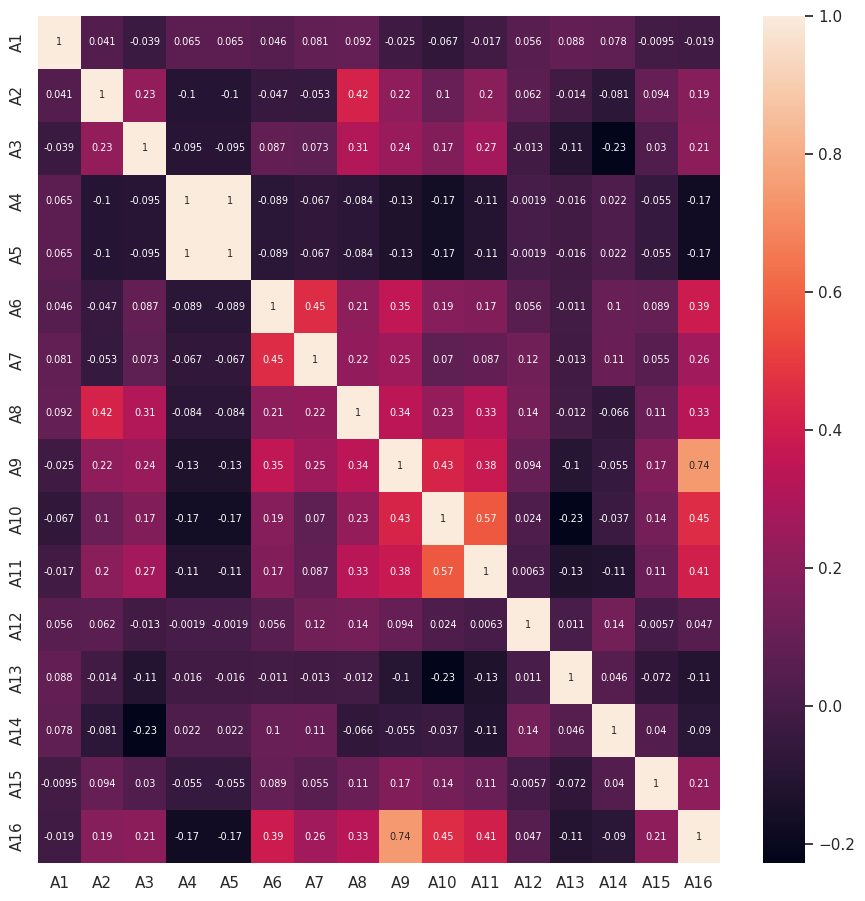

In [63]:
# Побудуємо матрицю кореляції та хітмапу, щоб краще побачити які фічі і наскільки корелюють між собою
plt.figure(figsize = (11,11))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 7});

Можна побачити що фічі майже не корелюють між собою. Винятком є кореляція фічі `А9` до таргету `А16`, але ця кореляція не є цілком вираженою. Ми продовжимо вчити модель на цих даних, але маємо на увазі що з фічою `A9` можна попрацювати додатково.

In [ ]:
# Розбиваємо датасет на X та Y
X = df.drop(columns="A16")  # фічі
Y = df["A16"]  # таргет

In [ ]:
# Ділемо датасет на тренувальну, валідаційну та тестові частини за схемою 60-20-20
from sklearn.model_selection import train_test_split

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

In [ ]:
# Спочатку спробуємо лінійну регресію на цих даних
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

grid_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={
        "fit_intercept": [True, False],
        "n_jobs": [1, 2, 4, 6, 8, 10],
        "positive": [True, False],
    },
)
grid_search.fit(x_valid, y_valid)

print("Результати тюнінгу гіперпараметрів для LinearRegression:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
grid_search.best_estimator_.fit(x_train, y_train)
predict = grid_search.best_estimator_.predict(x_test)

# Значення середньоквардатичної похибки
print("Результати тренування моделі:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    grid_search.best_estimator_.score(x_test, y_test) * 100,
)

Результати тюнінгу гіперпараметрів для LinearRegression: 

Найкращі параметри: {'fit_intercept': True, 'n_jobs': 1, 'positive': True}
Найкращий score: 0.5449440283650688 

Результати тренування моделі:
Середньоквадратична похибка: 0.10920677957563249
Точність моделі на тестових даних: 55.8047276142675


In [ ]:
# Тепер побудуємо DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [None, 10, 20, 50, 100, 1000],
        "min_samples_split": [2, 10, 20, 50, 100],
        "min_samples_leaf": [1, 10, 25, 50, 100],
        "min_weight_fraction_leaf": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "random_state": [42],
    },
)
grid_search.fit(x_valid, y_valid)

print("Результати тюнінгу гіперпараметрів для DecisionTreeClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
dtree = grid_search.best_estimator_
dtree.fit(x_train, y_train)
predict = dtree.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict, target_names=["-", "+"]))

Результати тюнінгу гіперпараметрів для DecisionTreeClassifier: 

Найкращі параметри: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Найкращий score: 0.8692307692307694 

Результати тренування моделі:
              precision    recall  f1-score   support

           -       0.90      0.79      0.84        72
           +       0.78      0.90      0.83        58

    accuracy                           0.84       130
   macro avg       0.84      0.84      0.84       130
weighted avg       0.85      0.84      0.84       130



In [ ]:
# Подивимось на предікт
list(zip(x_test.to_numpy(), predict, y_test))

[(array([ 1.        , 34.25      ,  3.        ,  0.        ,  0.        ,
          0.90846154,  0.56801584,  7.415     ,  1.        ,  0.        ,
          0.        ,  1.        ,  0.        ,  0.        ,  0.        ]),
  1,
  1),
 (array([  1.        ,  23.25      ,   4.        ,   0.        ,
           0.        ,   0.71126923,   0.45205025,   0.25      ,
           1.        ,   0.        ,   0.        ,   1.        ,
           0.        , 160.        ,   0.        ]),
  1,
  1),
 (array([  1.        ,  29.42      ,   1.25      ,   0.        ,
           0.        ,   0.57566075,   0.43543485,   1.75      ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        , 200.        ,   0.        ]),
  0,
  0),
 (array([  1.        ,  30.67      ,   2.5       ,   0.        ,
           0.        ,   0.9404142 ,   0.56801584,   2.25      ,
           0.        ,   0.        ,   0.        ,   1.        ,
           1.        , 340.        ,   0.        ]),

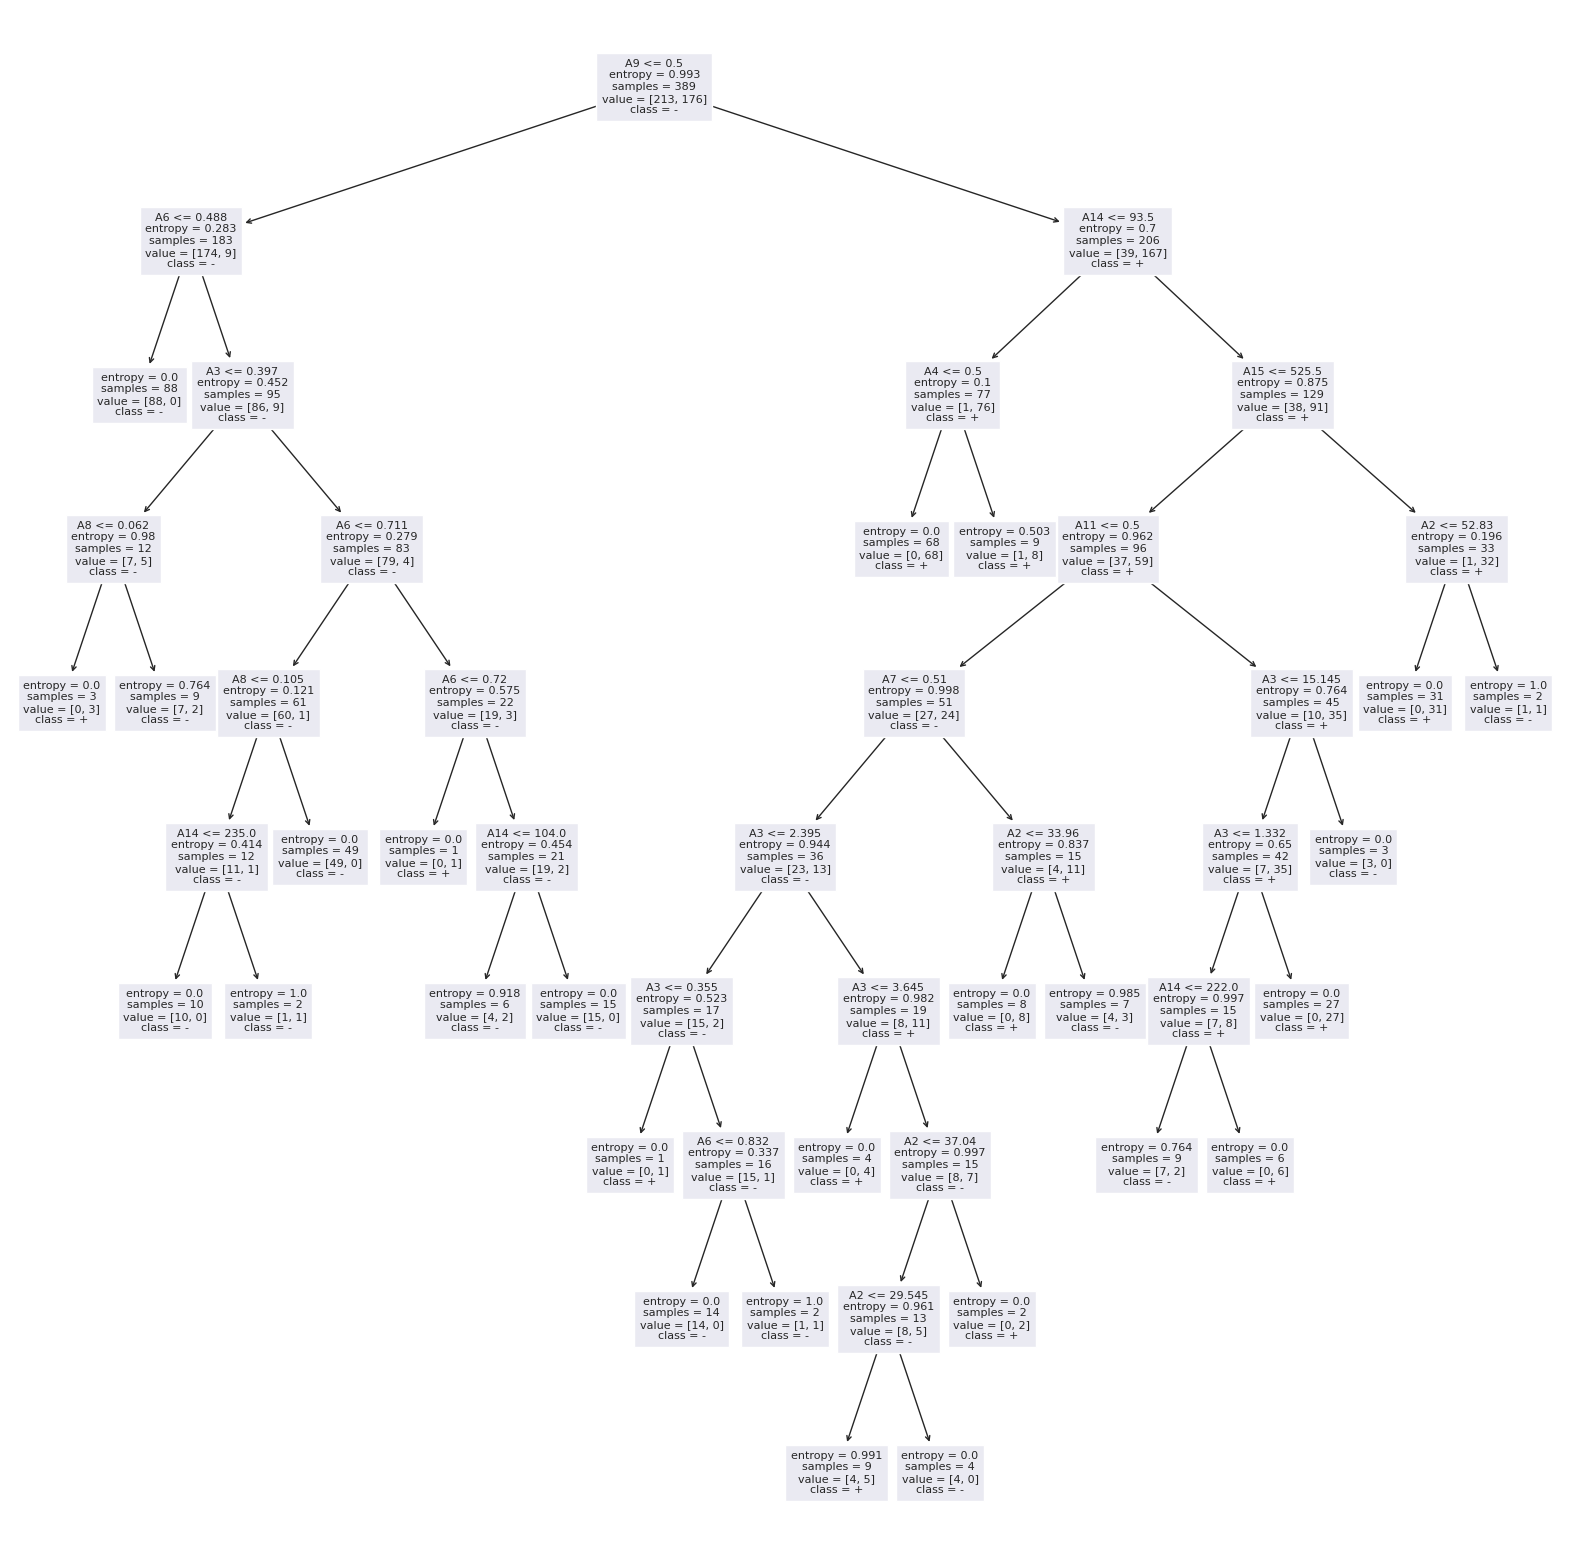

In [ ]:
# Подивимось на графічне представлення цього дерева
from sklearn import tree

plt.figure(figsize=(20, 20))
tree.plot_tree(dtree, feature_names=x_train.columns.to_list(), class_names=["-", "+"], fontsize=8)
plt.show()

# Додатково
Подивимось, чи впливає скейлінг датасету на якість моделі DecisionTreeClassifier.

In [ ]:
# Масштабуємо фічі за допомогою MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Ділемо датасет на тренувальну, валідаційну та тестові частини за схемою 60-20-20
from sklearn.model_selection import train_test_split

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

In [ ]:
# Використаємо попередньо отримані гіперпараметри для навчання моделі на тренувальних даних
dtree = DecisionTreeClassifier(
    **grid_search.best_params_,
)
dtree.fit(x_train, y_train)
predict = dtree.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict, target_names=["-", "+"]))

Результати тренування моделі:
              precision    recall  f1-score   support

           -       0.90      0.79      0.84        72
           +       0.78      0.90      0.83        58

    accuracy                           0.84       130
   macro avg       0.84      0.84      0.84       130
weighted avg       0.85      0.84      0.84       130



Можемо побачити що масштабування фічей не впливає на фінальну якість моделей типу вирішувальні дерева.

# Висновок
Вирішувальні дерева є непоганим рішенням для задач класифікації, але потребують ретельного контролю на предмет перенавчання. В цій роботі отримали практичний досвід використання таких моделей, а також навчилися будувати графічне представлення дерева.